In [1]:
import os
import sys
import json
import requests
import numpy as np
import pandas as pd
import pytz
import mpld3
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from urllib.request import Request, urlopen
from requests.models import PreparedRequest
from pydantic import BaseModel, Field
from enum import Enum
from typing import Optional, Dict, Any, List, Tuple
from pydantic_ai import Agent
import plotly.express as px
from rasterio.io import MemoryFile
import plotly.io as pio
import random

# local module
sys.path.append('/Users/williamharrigan/Desktop/hackathon/')
from codes import *

output_dir = '/Users/williamharrigan/Desktop/hackathon/'



In [2]:
prompt_process_query = """You are an AI assistant for the Hawai'i Climate Data Portal. 
You are responsible for answering the user query based on the results you get back from the tools.

When a user asks a query, carefully analyze the query and determine the best way to respond to the following questions:
1. What are the specific information the user is asking for?
2. What tools do you need to use to get the information?
3. What is the best way to format the response?

Plan your response step by step using the available tools and respond with the final answer only.

Output Format:
Only respond with the final answer. Do not lead the user to more conversation.
"""

In [3]:
prompt_process_agent = Agent(  
    # "groq:deepseek-r1-distill-llama-70b",
    "gemini-2.5-pro-exp-03-25",
    result_type=str,    
    system_prompt=prompt_process_query,
    model_settings={'temperature': 0.0}    
)

# You will be given a token to access the HCDP API. Add that token here.
hcdp_api_token = os.environ["hcdp_api_token"]
# Please input your email address. This will be used for user logging or distributing data packages
email = "akib_farts@stinky.edu"

api_base_url = "https://api.hcdp.ikewai.org"
# Setup header for API requests
header = {
  "Authorization": f"Bearer {hcdp_api_token}"
}

In [4]:
class DataType(str, Enum):
    TEMPERATURE = "temperature"
    RAINFALL = "rainfall"
    RELATIVE_HUMIDITY = "relative_humidity"
    NDVI_MODIS = "ndvi_modis"
    IGNITION_PROBABILITY = "ignition_probability"

class Aggregation(str, Enum):
    MIN = "min"
    MAX = "max"
    MEAN = "mean"

class Production(str, Enum):
    '''
    Production can be "new" or "legacy". Legacy rainfall maps are available from 1920-2012, whereas new rainfall maps are available from 1990-present
    '''
    NEW = "new"
    LEGACY = "legacy"

class Period(str, Enum):
    '''
    This is the resolution of the datapoints. NDVI_MODIS only has a DAY resolution. If user asks for year or month for NDVI, return DAY
    '''
    DAY = "day"
    MONTH = "month"
    YEAR = "year"

class Extent(str, Enum):
    '''
    HAWAII = Big Island, Hawai'i
    KAUAI = Kauai island, Hawai'i
    HONOLULU = O'ahu island, Hawai'i
    MLM = Moloka'i and Lanai islands, Maui island, 
    STATEWIDE = any time latitude and longitude coordinates are input, extent = statewide    
    '''
    STATEWIDE = "statewide"  # Data for the whole state
    HAWAII = "bi"            # Hawaii county
    KAUAI = "ka"             # Kauai county
    MLM = "mn"              # Maui, Molokai, Lanai county
    HONOLULU = "oa"          # Honolulu county

class ClimateDataParams(BaseModel):
    datatype: DataType
    period: Period
    start: str
    end: str
    extent: Extent
    lat: Optional[float] = None
    lng: Optional[float] = None
    # Optional fields that differ between temperature and rainfall
    aggregation: Optional[Aggregation] = None
    production: Optional[Production] = None


In [7]:
def pull_data(params):
    raster_timeseries_ep = "/raster/timeseries"
    api_base_url = 'https://api.hcdp.ikewai.org'
    raster_timeseries_ep = '/raster/timeseries'
    url = f"{api_base_url}{raster_timeseries_ep}"

    params = dict(params)
    res = requests.get(url, params, headers = header)
    res.raise_for_status()
    # print(f"Constructed API request URL: {res.url}")
    data = res.json()
    
    return data

In [8]:
# def plot_bar_graph(comparison_results: Dict[str, Any], title: str = "Climate Data Comparison") -> None:
#     """
#     Creates a bar graph to visualize the comparison results from climate data.
    
#     Args:
#         comparison_results (Dict[str, Any]): Dictionary containing comparison results from compare_climate_data
#         title (str): Title for the bar graph
        
#     Returns:
#         None: Displays the plot
#     """
    
#     # Extract parameters and values from results
#     parameters = list(comparison_results.keys())
#     values = list(comparison_results.values())
    
#     # Set up the figure and axis
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     # Create the bar chart
#     bar_positions = np.arange(len(parameters))
#     bars = ax.bar(bar_positions, values, width=0.6)
    
#     # Add parameter labels
#     ax.set_xticks(bar_positions)
#     ax.set_xticklabels(parameters, rotation=45, ha='right')
    
#     # Add value labels on top of each bar
#     for bar in bars:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
#                 f'{height:.2f}', ha='center', va='bottom')
    
#     # Set title and labels
#     ax.set_title(title)
#     ax.set_ylabel('Value')
#     parameter_desc = {
#         'ignition_probability': 'Probability (0-1)',
#         'temperature': 'Temperature (°C)',
#         'rainfall': 'Rainfall (mm)',
#         'relative_humidity': 'Relative Humidity (%)',
#         'ndvi': 'NDVI Value'
#     }
    
#     # Add a second y-axis label with parameter descriptions if applicable
#     descriptions = []
#     for param in parameters:
#         if param in parameter_desc:
#             descriptions.append(parameter_desc[param])
    
#     if descriptions:
#         description_text = '\n'.join(f"• {param}: {desc}" for param, desc in zip(parameters, descriptions))
#         plt.figtext(0.01, 0.01, f"Parameters:\n{description_text}", fontsize=8)
    
#     # Format the plot
#     plt.tight_layout()
#     plt.grid(axis='y', linestyle='--', alpha=0.7)
    
#     # Add colorful bars with different colors for different parameters
#     colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
#     for i, bar in enumerate(bars):
#         bar.set_color(colors[i % len(colors)])
    
#     # Show the plot
#     # plt.show()
#     fig.to_html()
#     return fig

# # Example usage:
# # climate_data = compare_climate_data(
# #     compare_ignition_probability=True,
# #     compare_rainfall=True,
# #     compare_temperature=True,
# #     compare_relative_humidity=True,
# #     compare_ndvi=True,
# #     lat=21.3069,
# #     lng=-157.8583,
# #     aggregation="mean"
# # )
# # plot_bar_graph(climate_data, title="Hawaii Climate Data Comparison")

In [ ]:
def plot_bar_graph(comparison_results: Dict[str, Any], title: str = "Climate Data Comparison", output_dir: str = ".") -> None:
    """
    Creates a bar graph to visualize the comparison results from climate data and saves it as an HTML file.
    
    Args:
        comparison_results (Dict[str, Any]): Dictionary containing comparison results from compare_climate_data
        title (str): Title for the bar graph
        output_dir (str): Directory where the HTML file will be saved (default: current directory)
        
    Returns:
        None: Saves the plot as HTML and returns the figure object
    """# Make sure you have this installed: pip install mpld3
    
    # Extract parameters and values from results
    parameters = list(comparison_results.keys())
    values = list(comparison_results.values())
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the bar chart
    bar_positions = np.arange(len(parameters))
    bars = ax.bar(bar_positions, values, width=0.6)
    
    # Add parameter labels
    ax.set_xticks(bar_positions)
    ax.set_xticklabels(parameters, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom')
    
    # Set title and labels
    ax.set_title(title)
    ax.set_ylabel('Value')
    parameter_desc = {
        'ignition_probability': 'Probability (0-1)',
        'temperature': 'Temperature (°C)',
        'rainfall': 'Rainfall (mm)',
        'relative_humidity': 'Relative Humidity (%)',
        'ndvi': 'NDVI Value'
    }
    
    # Add a second y-axis label with parameter descriptions if applicable
    descriptions = []
    for param in parameters:
        if param in parameter_desc:
            descriptions.append(parameter_desc[param])
    
    if descriptions:
        description_text = '\n'.join(f"• {param}: {desc}" for param, desc in zip(parameters, descriptions))
        plt.figtext(0.01, 0.01, f"Parameters:\n{description_text}", fontsize=8)
    
    # Format the plot
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add colorful bars with different colors for different parameters
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    for i, bar in enumerate(bars):
        bar.set_color(colors[i % len(colors)])
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save the plot as an HTML file
    # html_file_path = os.path.join(output_dir, "bar_graph.html")
    html_content = mpld3.fig_to_html(fig)
    
    with open("/Users/williamharrigan/Desktop/hackathon/bargraph.html", "w") as f:
        f.write(html_content)
    
    print(f"Bar graph saved as HTML at: /Users/williamharrigan/Desktop/hackathon/bargraph.html")
    
    # Return the figure for further use if needed
    return 

# Example usage:
# climate_data = compare_climate_data(
#     compare_ignition_probability=True,
#     compare_rainfall=True,
#     compare_temperature=True,
#     compare_relative_humidity=True,
#     compare_ndvi=True,
#     lat=21.3069,
#     lng=-157.8583,
#     aggregation="mean"

In [10]:
# @prompt_process_agent.tool_plain 
# def compare_climate_data(
#     compare_ignition_probability=False,
#     compare_temperature=False,
#     compare_rainfall=False,
#     compare_relative_humidity=False,
#     compare_ndvi=False,
#     aggregation: Optional[Aggregation] = Aggregation.MEAN,
#     lat: float,     
#     lng: float,     
#     start_date: Optional[str] = None,      
#     end_date: Optional[str] = None,
#     # production: Production = Production.NEW,
#     extent: Optional[Extent] = Extent.STATEWIDE
# ) -> Dict[str, Any]:
#     """
#     Tool to compare different climate data parameters.
    
#     Args:
#         compare_ignition_probability (bool): Whether to compare ignition probability data
#         compare_temperature (bool): Whether to compare temperature data
#         compare_rainfall (bool): Whether to compare rainfall data
#         compare_relative_humidity (bool): Whether to compare relative humidity data
#         compare_ndvi (bool): Whether to compare NDVI (Normalized Difference Vegetation Index) data
        
#     Returns:
#         Dict[str, Any]: Dictionary containing comparison results for the selected parameters
#     """
#     api = ClimateAPI(api_base_url=api_base_url, header=header)  
#     today = datetime.now(pytz.timezone("US/Hawaii"))     
#     yesterday = today - timedelta(days=1)     
#     previous_year = today - relativedelta(years=1)          

#     start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
#     end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")
    
#     results = {}
    
#     if compare_ignition_probability:
#         params = ClimateDataParams(         
#         datatype="ignition_probability",         
#         # production="new",         
#         period="day", 
#         start = start_str,
#         end = end_str,
#         extent=extent,    
#         lat=lat,         
#         lng=lng     
#     )  
        
#         ignition_data = pull_data(params)
#         if aggregation = "mean":
#             results["ignition_probability"] = np.mean(list(ignition_data.values()))
#         elif aggregation = "min":
#             results["ignition_probability"] = np.min(list(ignition_data.values()))
#         elif aggregation = "max":
#             results["ignition_probability"] = np.max(list(ignition_data.values()))        
        
#     if compare_temperature:
#         params = ClimateDataParams(         
#         datatype="ndvi_modis",         
#         aggregation=aggregation,         
#         period="day", 
#         start = start_str,
#         end = end_str,
#         extent=extent,    
#         lat=lat,         
#         lng=lng     
#     )  
#         temperature_data = pull_data(params)
#         if aggregation = "mean":
#             results["temperature"] = np.mean(list(temperature_data.values()))
#         elif aggregation = "min":
#             results["temperature"] = np.min(list(temperature_data.values()))
#         elif aggregation = "max":
#             results["temperature"] = np.max(list(temperature_data.values()))
        
#     if compare_rainfall:
#         params = ClimateDataParams(         
#         datatype="rainfall",         
#         production="new",         
#         period="day", 
#         start = start_str,
#         end = end_str,
#         extent=extent,    
#         lat=lat,         
#         lng=lng     
#     )  
#         rainfall_data = pull_data(params)
#         if aggregation = "mean":
#             results["rainfall"] = np.mean(list(rainfall_data.values()))
#         elif aggregation = "min":
#             results["rainfall"] = np.min(list(rainfall_data.values()))
#         elif aggregation = "max":
#             results["rainfall"] = np.max(list(rainfall_data.values()))
        
#     if compare_relative_humidity:
#         params = ClimateDataParams(         
#         datatype="relative_humidity",         
#         # production="new",         
#         period="day", 
#         start = start_str,
#         end = end_str,
#         extent=extent,    
#         lat=lat,         
#         lng=lng     
#     )  
#         relative_humidity_data = pull_data(params)
#         if aggregation = "mean":
#             results["relative_humidity"] = np.mean(list(relative_humidity_data.values()))
#         elif aggregation = "min":
#             results["relative_humidity"] = np.min(list(relative_humidity_data.values()))
#         elif aggregation = "max":
#             results["relative_humidity"] = np.max(list(relative_humidity_data.values()))
        
        
#     if compare_ndvi:
#         params = ClimateDataParams(         
#         datatype="ndvi_modis",         
#         # production="new",         
#         period="day", 
#         start = start_str,
#         end = end_str,
#         extent=extent,    
#         lat=lat,         
#         lng=lng     
#     )  
#         ndvi_data = pull_data(params)
        
#         if aggregation = "mean":
#             results["ndvi"] = np.mean(list(ndvi_data.values()))
#         elif aggregation = "min":
#             results["ndvi"] = np.min(list(ndvi_data.values()))
#         elif aggregation = "max":
#             results["ndvi"] = np.max(list(ndvi_data.values()))
    
#     return results

In [11]:
class ClimateAPI:     
    def __init__(self, api_base_url: str, header: Dict[str, str]):         
        self.api_base_url = api_base_url         
        self.header = header         
        self.raster_timeseries_ep = "/raster/timeseries"  

    @prompt_process_agent.tool_plain 
    def compare_climate_data(
        lat: float,     
        lng: float,
        compare_ignition_probability: bool = False,
        compare_temperature: bool = False,
        compare_rainfall: bool = False,
        compare_relative_humidity: bool = False,
        compare_ndvi: bool = False,
        aggregation: Optional[Aggregation] = Aggregation.MEAN,
        start_date: Optional[str] = None,      
        end_date: Optional[str] = None,
        # production: Production = Production.NEW,
        extent: Optional[Extent] = Extent.STATEWIDE
    ) -> Dict[str, Any]:
        """
        Tool to compare different climate data parameters.
        
        Args:
            lat (float): Latitude coordinate
            lng (float): Longitude coordinate
            compare_ignition_probability (bool): Whether to compare ignition probability data
            compare_temperature (bool): Whether to compare temperature data
            compare_rainfall (bool): Whether to compare rainfall data
            compare_relative_humidity (bool): Whether to compare relative humidity data
            compare_ndvi (bool): Whether to compare NDVI (Normalized Difference Vegetation Index) data
            aggregation (Optional[Aggregation]): Method to aggregate data (default: MEAN)
            start_date (Optional[str]): Start date for data range (format: YYYY-MM-DD)
            end_date (Optional[str]): End date for data range (format: YYYY-MM-DD)
            extent (Optional[Extent]): Geographical extent for data (default: STATEWIDE)
            
        Returns:
            Dict[str, Any]: Dictionary containing comparison results for the selected parameters
        """
        api = ClimateAPI(api_base_url=api_base_url, header=header)  
        today = datetime.now(pytz.timezone("US/Hawaii"))     
        yesterday = today - timedelta(days=1)     
        previous_year = today - relativedelta(years=1)          

        start_str = start_date if start_date else previous_year.strftime("%Y-%m-%d")     
        end_str = end_date if end_date else yesterday.strftime("%Y-%m-%d")
        
        results = {}
        
        if compare_ignition_probability:
            params = ClimateDataParams(         
            datatype="ignition_probability",         
            # production="new",         
            period="day", 
            start = start_str,
            end = end_str,
            extent=extent,    
            lat=lat,         
            lng=lng     
        )  
            
            ignition_data = pull_data(params)
            if aggregation == "mean":
                results["ignition_probability"] = np.mean(list(ignition_data.values()))
            elif aggregation == "min":
                results["ignition_probability"] = np.min(list(ignition_data.values()))
            elif aggregation == "max":
                results["ignition_probability"] = np.max(list(ignition_data.values()))        
            
        if compare_temperature:
            params = ClimateDataParams(         
            datatype="temperature",         
            aggregation=aggregation,         
            period="day", 
            start = start_str,
            end = end_str,
            extent=extent,    
            lat=lat,         
            lng=lng     
        )  
            temperature_data = pull_data(params)
            if aggregation == "mean":
                results["temperature"] = np.mean(list(temperature_data.values()))
            elif aggregation == "min":
                results["temperature"] = np.min(list(temperature_data.values()))
            elif aggregation == "max":
                results["temperature"] = np.max(list(temperature_data.values()))
            
        if compare_rainfall:
            params = ClimateDataParams(         
            datatype="rainfall",         
            production="new",         
            period="day", 
            start = start_str,
            end = end_str,
            extent=extent,    
            lat=lat,         
            lng=lng     
        )  
            rainfall_data = pull_data(params)
            if aggregation == "mean":
                results["rainfall"] = np.mean(list(rainfall_data.values()))
            elif aggregation == "min":
                results["rainfall"] = np.min(list(rainfall_data.values()))
            elif aggregation == "max":
                results["rainfall"] = np.max(list(rainfall_data.values()))
            
        if compare_relative_humidity:
            params = ClimateDataParams(         
            datatype="relative_humidity",         
            # production="new",         
            period="day", 
            start = start_str,
            end = end_str,
            extent=extent,    
            lat=lat,         
            lng=lng     
        )  
            relative_humidity_data = pull_data(params)
            if aggregation == "mean":
                results["relative_humidity"] = np.mean(list(relative_humidity_data.values()))
            elif aggregation == "min":
                results["relative_humidity"] = np.min(list(relative_humidity_data.values()))
            elif aggregation == "max":
                results["relative_humidity"] = np.max(list(relative_humidity_data.values()))
            
            
        if compare_ndvi:
            params = ClimateDataParams(         
            datatype="ndvi_modis",         
            # production="new",         
            period="day", 
            start = start_str,
            end = end_str,
            extent=extent,    
            lat=lat,         
            lng=lng     
        )  
            ndvi_data = pull_data(params)
            
            if aggregation == "mean":
                results["ndvi"] = np.mean(list(ndvi_data.values()))
            elif aggregation == "min":
                results["ndvi"] = np.min(list(ndvi_data.values()))
            elif aggregation == "max":
                results["ndvi"] = np.max(list(ndvi_data.values()))
        
        
        plot_bar_graph(results)
        return results

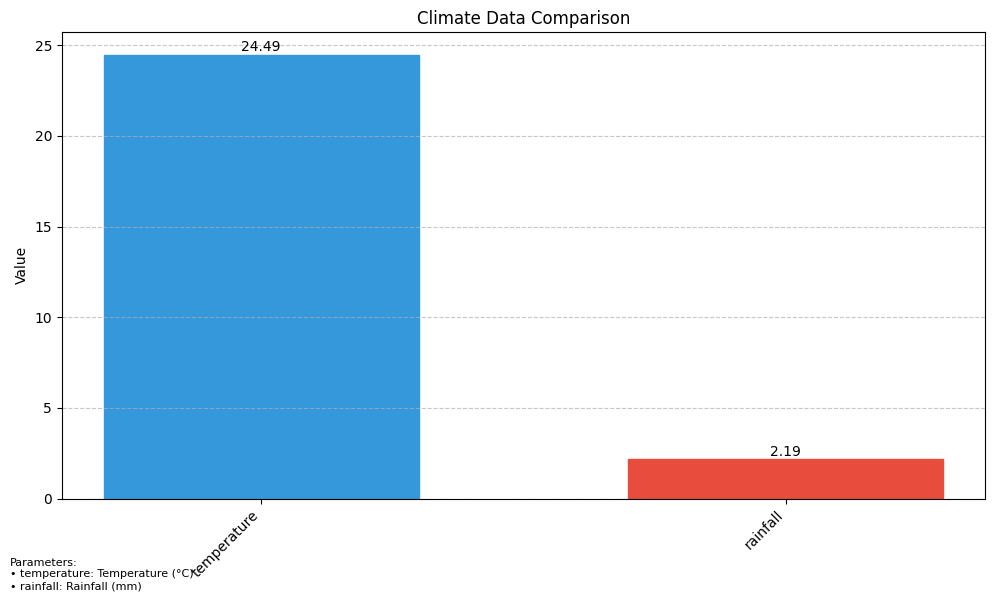

In [21]:
r = await prompt_process_agent.run("Give me a bar graph comparing the mean daily temperature vs the mean daily rainfall at the coordinates lat=21.2998, lng=-157.8148 from 2010 to 2020.")    

In [13]:
output_dir

'/Users/williamharrigan/Desktop/hackathon/'